In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git config --global user.name "alistvt"
!git config --global user.email "alistvt@gmail.com"

%cd /content/drive/MyDrive/multidoc-conv-qa/src/retriever

/content/drive/MyDrive/multidoc-conv-qa/src/retriever


In [4]:
!pip install -r ../../requirements.txt --quiet
!pip install --quiet transformers datasets accelerate

     |████████████████████████████████| 3.8 MB 8.8 MB/s 
     |████████████████████████████████| 76 kB 4.7 MB/s 
     |████████████████████████████████| 325 kB 53.8 MB/s 
     |████████████████████████████████| 10.6 MB 41.5 MB/s 
     |████████████████████████████████| 159 kB 52.2 MB/s 
     |████████████████████████████████| 680 kB 44.7 MB/s 
     |████████████████████████████████| 1.2 MB 42.2 MB/s 
     |████████████████████████████████| 248 kB 54.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 880 kB 44.2 MB/s 
     |████████████████████████████████| 120 kB 51.3 MB/s 
     |████████████████████████████████| 6.6 MB 41.8 MB/s 
     |████████████████████████████████| 115 kB 52.5 MB/s 
     |████████████████████████████████| 212 kB 52.8 MB/s 
     |████████████████████████████████| 184 kB 56.2 MB/s 
     |███████████████

# Document Retrival with Follow up Detector (DR.FUD) + DR. TEIT

In this method we use a FCN to detect wheter a question is a follow up of the previous question, meaning that the document is the same of not. If the document is the same, we use the previous answer's document for this question also.

We used LaBSE model for out embeddings. For computing title embedding similarities we used cosine similarity between query embeddings and each document's title embedding.

# Dataset
### Dataset Description

- **mutldoc2dial_doc.json** contains the documents that are indexed by key `domain` and `doc_id` . Each document instance includes the following,

  - `doc_id`: the ID of a document;
  - `title`: the title of the document;
  - `domain`: the domain of the document;
  - `doc_text`: the text content of the document (without HTML markups);
  - `doc_html_ts`: the document content with HTML markups and the annotated spans that are indicated by `text_id` attribute, which corresponds to `id_sp`.
  - `doc_html_raw`: the document content with HTML markups and without span annotations.
  - `spans`: key-value pairs of all spans in the document, with `id_sp` as key. Each span includes the following,
    - `id_sp`: the id of a  span as noted by `text_id` in  `doc_html_ts`;
    - `start_sp`/  `end_sp`: the start/end position of the text span in `doc_text`;
    - `text_sp`: the text content of the span.
    - `id_sec`: the id of the (sub)section (e.g. `<p>`) or title (`<h2>`) that contains the span.
    - `start_sec` / `end_sec`: the start/end position of the (sub)section in `doc_text`.
    - `text_sec`: the text of the (sub)section.
    - `title`: the title of the (sub)section.
    - `parent_titles`: the parent titles of the `title`.

- **multidoc2dial_dial_train.json** and **multidoc2dial_dial_validation.json**  contain the training and dev split of dialogue data that are indexed by key `domain` . Please note: **For test split, we only include a dummy file in this version.**

  Each dialogue instance includes the following,

  - `dial_id`: the ID of a dialogue;
  - `turns`: a list of dialogue turns. Each turn includes,
    - `turn_id`: the time order of the turn;
    - `role`: either "agent" or "user";READ
    - `da`: dialogue act;
    - `references`: a list of spans with `id_sp` ,  `label` and `doc_id`. `references` is empty if a turn is for indicating previous user query not answerable or irrelevant to the document. **Note** that labels "*precondition*"/"*solution*" are fuzzy annotations that indicate whether a span is for describing a conditional context or a solution.
    - `utterance`: the human-generated utterance based on the dialogue scene.
Downloading the training dataset:

In [5]:
import json
with open('../../dataset/multidoc2dial/v1.0/multidoc2dial_doc.json', 'r') as f:
    multidoc2dial_doc = json.load(f)

#### Extracting titles

In [6]:
titles = []
for doc_idx1 in multidoc2dial_doc['doc_data']:
    for doc_idx2 in multidoc2dial_doc['doc_data'][doc_idx1]:
        titles.append(doc_idx2)

#### Extracting document texts

In [7]:
doc_texts_train = []
title_to_domain = {}
for doc_idx1 in multidoc2dial_doc['doc_data']:
    for doc_idx2 in multidoc2dial_doc['doc_data'][doc_idx1]:
        doc_texts_train.append(multidoc2dial_doc['doc_data'][doc_idx1]\
                                          [doc_idx2]['doc_text'].strip())
        title_to_domain[doc_idx2] = doc_idx1

## Encoding the sentences
We use the LaBSE which is a Language-agnostic BERT Sentence Encoder (LaBSE) is a BERT-based model trained for sentence embedding for 109 languages. The pre-training process combines masked language modeling with translation language modeling. The model is useful for getting multilingual sentence embeddings and for bi-text retrieval.

In [8]:
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
import numpy as np
import torch
from torch.nn.functional import normalize

from tqdm import tqdm

model_name = "setu4993/LaBSE"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/300 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.98M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.18M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/576 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

### `get_embeddings`
In this method we extract the **pooler output** (Last layer hidden-state of the first token of the sequence (classification token) after further processing through the layers used for the auxiliary pretraining task. E.g. for BERT-family of models, this returns the classification token after processing through a linear layer and a tanh activation function. The linear layer weights are trained from the next sentence prediction (classification) objective during pretraining).

In [9]:
def get_embeddings(sentece):
    """
    Return embeddings based on encoder model

    :param sentence: input sentence(s)
    :type sentence: str or list of strs
    :return: embeddings
    """
    tokenized = tokenizer(sentece,
                                return_tensors="pt",
                                padding=True)
    with torch.no_grad():
        embeddings = model(**tokenized)
    
    return np.squeeze(np.array(embeddings.pooler_output))

### Title embedding

In [10]:
import os
title_embeddings_file = 'doc_title_LaBSE_Embedding.npy'

if not os.path.exists(title_embeddings_file):
    title_embeddings = []
    for title in tqdm(titles):
        title_embeddings.append(get_embeddings(title))

    with open(title_embeddings_file, 'wb') as f:
        np.save(f, np.array(title_embeddings))
else:
    title_embeddings = np.load(title_embeddings_file)
    title_embeddings = list(title_embeddings)


In [11]:
import pickle
title_to_embeddings_file = 'title_to_embeddings.pkl'

if not os.path.exists(title_to_embeddings_file):
    title_to_embeddings = {}
    for title in tqdm(titles):
        title_to_embeddings[title] = get_embeddings(title)
    with open(title_to_embeddings_file, 'wb') as f:
        pickle.dump(title_to_embeddings, f)
else:
    with open(title_to_embeddings_file, 'rb') as f:
        title_to_embeddings = pickle.load(f)

## Calculating the IDF for each token

In [12]:
words_idf_file = 'IDFs.pkl'
N_doc = len(doc_texts_train)

if not os.path.exists(words_idf_file):
    # First getting all distinct words in all documents
    words = set()
    doc_texts_train_tokenized = []
    for doc in tqdm(doc_texts_train, desc="getting all words from documents"):
        tokenized_doc = [s.lower() for s in tokenizer.tokenize(doc)]
        doc_texts_train_tokenized.append(tokenized_doc) 
        words = set(tokenized_doc).union(words)

    # calculating each word IDF
    words2IDF = {}
    for word in tqdm(words, desc="calculating words IDF scores"):
        n_word = 0
        for doc in doc_texts_train_tokenized:
            if word in doc:
                n_word += 1
        words2IDF[word] = np.log(N_doc / (n_word + 1))

    with open(words_idf_file, 'wb') as f:
        pickle.dump(words2IDF, f)

else:
    with open(words_idf_file, 'rb') as f:
        words2IDF = pickle.load(f)

In [13]:
len(words2IDF)

8446

In [14]:
def calc_idf_score(sentence):
    """
    Calculate the mean idf score for given sentence.
    (used to understand the contribution of the knowledge of each question
    questions with high frequent words are meaningless and we can ignore them
    roughly, which is done by this score.)

    :param sentence: input sentence
    :type sentence: str
    :return: mean idf score of sentence token
    """
    tokenzied_sentence = [s.lower() for s in tokenizer.tokenize(sentence)]
    score = 0
    for token in tokenzied_sentence:
        if token in words2IDF:
            score += words2IDF[token]
        else:
            score += np.log(N_doc)
    return score / len(tokenzied_sentence) if len(tokenzied_sentence) else 0

## Constructing the Follow-up Dataset

``` history | question | is_follow_up```

is_follow_up: shows that the history's document is the same as the current question's.

In [15]:
def combine_sentences(s1, s2):
    separation_token = " <SEP> "
    return s1 + separation_token + s2


def construct_followup_dataset(filepath):
    import json
    with open(filepath, 'r') as f:
        multidoc2dial_dial_train = json.load(f)
    
    historys = []
    questions = []
    combined = []
    labels = []
    prev_docs = []
    current_docs = []
    prev_answers = []

    for domain in multidoc2dial_dial_train['dial_data']:
        for dial in multidoc2dial_dial_train['dial_data'][domain]:
            prev_doc = ''
            prev_question = ''
            prev_answer = ''
            for turn in dial['turns']:
                if turn['role'] == "user":
                    current_question = turn['utterance']
                    historys.append(prev_question)
                    questions.append(current_question)
                    
                    combined.append(combine_sentences(prev_question, current_question))

                    current_doc = turn['references'][0]['doc_id']
                    labels.append(int(current_doc==prev_doc))

                    prev_docs.append(prev_doc)
                    current_docs.append(current_doc)
                    prev_answers.append(prev_answer)

                    prev_doc, prev_question = current_doc, current_question
                else:
                    prev_answer = turn['utterance']
                    
    return historys, questions, combined, labels, prev_docs, current_docs, prev_answers

In [16]:
import pandas as pd

train_history, train_questions, train_combined, train_labels, train_prev_docs, train_current_docs, train_prev_answers = construct_followup_dataset('../../dataset/multidoc2dial/v1.0/multidoc2dial_dial_train.json')
test_history, test_questions, test_combined, test_labels, test_prev_docs, test_current_docs, test_prev_answers = construct_followup_dataset('../../dataset/multidoc2dial/v1.0/multidoc2dial_dial_validation.json')

train_dict_dataset = {"history":train_history, "question": train_questions, "combined": train_combined, "followup": train_labels, "prev_doc": train_prev_docs, "current_doc": train_current_docs, "prev_answer": train_prev_answers}
test_dict_dataset = {"history":test_history, "question": test_questions, "combined": test_combined, "followup": test_labels, "prev_doc": test_prev_docs, "current_doc": test_current_docs, "prev_answer": test_prev_answers}

train_df = pd.DataFrame(train_dict_dataset)
test_df = pd.DataFrame(test_dict_dataset)

In [17]:
max([len(x["combined"].split()) for _, x in test_df.iterrows()])

74

In [18]:
train_df

,history,question,combined,followup,prev_doc,current_doc,prev_answer
0,,"Hello, I forgot o update my address, can you h...","<SEP> Hello, I forgot o update my address, ca...",0,,Top 5 DMV Mistakes and How to Avoid Them#3_0,
1,"Hello, I forgot o update my address, can you h...",Can I do my DMV transactions online?,"Hello, I forgot o update my address, can you h...",1,Top 5 DMV Mistakes and How to Avoid Them#3_0,Top 5 DMV Mistakes and How to Avoid Them#3_0,"hi, you have to report any change of address t..."
2,Can I do my DMV transactions online?,You've got it. Another query about DMV. What h...,Can I do my DMV transactions online? <SEP> You...,0,Top 5 DMV Mistakes and How to Avoid Them#3_0,Registration suspensions for failure to pay to...,"Yes, you can sign up for MyDMV for all the onl..."
3,You've got it. Another query about DMV. What h...,"Besides that, will I receive a notice?",You've got it. Another query about DMV. What h...,1,Registration suspensions for failure to pay to...,Registration suspensions for failure to pay to...,the suspension is placed on hold pending the o...
4,"Besides that, will I receive a notice?",If you submit the affidavit?,"Besides that, will I receive a notice? <SEP> I...",1,Registration suspensions for failure to pay to...,Registration suspensions for failure to pay to...,"the NYS Department of Motor Vehicles , "" DMV ..."
...,...,...,...,...,...,...,...
23394,"By the way, who can I contact to give me infor...",What if I've fallen behind on one or more loan...,"By the way, who can I contact to give me infor...",0,Loan Servicers | Federal Student Aid#1_0,Student Loan Repayment | Federal Student Aid#1_0,Your school's financial aid office must have t...
23395,What if I've fallen behind on one or more loan...,I have another question regarding the Military...,What if I've fallen behind on one or more loan...,0,Student Loan Repayment | Federal Student Aid#1_0,Student Loan Deferment | Federal Student Aid#1_0,One thing you definitely want to avoid is goin...
23396,I have another question regarding the Military...,something else I want to ask about FAFSA. What...,I have another question regarding the Military...,0,Student Loan Deferment | Federal Student Aid#1_0,Student Loan Repayment | Federal Student Aid#1_0,You will have to complete the Military Service...
23397,something else I want to ask about FAFSA. What...,How can I make a payment by post?,something else I want to ask about FAFSA. What...,1,Student Loan Repayment | Federal Student Aid#1_0,Student Loan Repayment | Federal Student Aid#1_0,contact your loan servicer to find out your op...


In [19]:
def tokenize_function(examples, prediction=False, cuda=False):
    if prediction:
        tokenized = tokenizer(examples['combined'], max_length=128, padding="max_length", truncation=True, return_tensors='pt')
    else:
        tokenized = tokenizer(examples['combined'], max_length=128, padding="max_length", truncation=True)
    if cuda:
        tokenized_cuda = {}
        for key, value in tokenized.items():
            tokenized_cuda[key] = value.cuda()
        return tokenized_cuda
    else:
        return tokenized

### constructing dataloader

In [20]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenized_trainset = train_dataset.map(tokenize_function, batched=True)
tokenized_testset = test_dataset.map(tokenize_function, batched=True)

tokenized_trainset = tokenized_trainset.rename_column("followup", "label")
tokenized_testset = tokenized_testset.rename_column("followup", "label")

fud_dataset = DatasetDict()

fud_dataset['train'] = tokenized_trainset
fud_dataset['validation'] = tokenized_testset


  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

# Methods

## FCN based on [cls]

### AutoModelForSequenceClassification

We use a classification method on the questions to decide the relationship between the previous question and current question.
In the dataset provided to us, previous turn documents are predefined, meaning that we are aware of the previous documents, therefore, if the prediction predicts that current question's document is the same as the previous, we don't need to retrieve a document and we give the previous doc_id.

#### model

In [21]:
model_name = "setu4993/LaBSE"

tokenizer = AutoTokenizer.from_pretrained(model_name)
fudnet_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = torch.device("cuda:0")
fudnet_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at setu4993/LaBSE and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(501153, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

#### metrics

In [22]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

#### train

In [23]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='/home/',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=50,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy ='epoch',
    load_best_model_at_end=True,
    # auto_find_batch_size=True,
)

trainer = Trainer(
    model=fudnet_model,
    args=training_args,
    train_dataset=fud_dataset['train'],
    eval_dataset=fud_dataset['validation'],
    compute_metrics=compute_metrics
)

In [24]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: combined, current_doc, prev_answer, history, question, prev_doc. If combined, current_doc, prev_answer, history, question, prev_doc are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 23399
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1464


Epoch,Training Loss,Validation Loss,Accuracy
1,0.172100,0.144127,0.949066
2,0.094800,0.137107,0.954404


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: combined, current_doc, prev_answer, history, question, prev_doc. If combined, current_doc, prev_answer, history, question, prev_doc are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4496
  Batch size = 32
Saving model checkpoint to /home/checkpoint-732
Configuration saved in /home/checkpoint-732/config.json
Model weights saved in /home/checkpoint-732/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: combined, current_doc, prev_answer, history, question, prev_doc. If combined, current_doc, prev_answer, history, question, prev_doc are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Run

TrainOutput(global_step=1464, training_loss=0.1559999535481135, metrics={'train_runtime': 779.0272, 'train_samples_per_second': 60.072, 'train_steps_per_second': 1.879, 'total_flos': 3078267792184320.0, 'train_loss': 0.1559999535481135, 'epoch': 2.0})

### DR. TEIT*

In this method we used two scoring measure and aggregate them by a convex combination as below:
$$
λ*Similiarity_{Title Embedding} + (1-λ)*Similiarity_{TextIDF}
$$

We used LaBSE model for our embeddings. For computing title embedding similarities we used cosine similarity between query embeddings and each document's title embedding.

For the second part we used character-level (2gram to 8gram). We also trained our TF-IDF transformation matrix on the Multidoc2dial2022 documnets.

**NOTE: In `predict_DR_TEIT` you may see a diffrent notation (`alpha`) but they are the same.**

#### TF-IDF Transformation Matrix Fitting

In [25]:
doc_texts_train = []
for doc_idx1 in multidoc2dial_doc['doc_data']:
    for doc_idx2 in multidoc2dial_doc['doc_data'][doc_idx1]:
        doc_texts_train.append(multidoc2dial_doc['doc_data'][doc_idx1]\
                                          [doc_idx2]['doc_text'].strip())

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer(strip_accents=None,
                                 analyzer='char',
                                 ngram_range=(2, 8),
                                 norm='l2',
                                 use_idf=True,
                                 smooth_idf=True)
tfidf_wm = tfidfVectorizer.fit_transform(doc_texts_train)

In [27]:
import pickle
with open('tfidfVectorizer.pkl', 'wb') as f:
    pickle.dump(tfidfVectorizer, f)

with open('tfidf_wm.pkl', 'wb') as f:
    pickle.dump(tfidf_wm, f)

In [28]:
len(tfidfVectorizer.get_feature_names_out())

1047632

#### DR. TEIT

the input is consisted of a list of queries, which is the current question and its history turns.
for each of the questions, we compute two similarity score for each of our documents, one of them is based on the pretrained LM and the other on is based on character level matching. Both of these scores will be weighted by a coefficient which is the `idf_score` of the query, defining how much meaning does the query contain. Then these scores will be summed up in a convex manner and the final matching score with all documents is computed. We return the result by sorting these scores.

In [29]:
def predict_DR_TEIT(queries, k=1, alpha=10):
    """
    Predict which document is matched to the given query.

    :param queries: input queries in time reversed order (latest first)
    :type queries: str (or list of strs)
    :param k: number of returning docs
    :type k: int 
    :return: return the document names and accuracies
    """

    idf_score = np.array(list(map(lambda x: 0.0, title_embeddings)))
    tfidf_score = np.array(list(map(lambda x: 0.0, title_embeddings)))
    coef_sum = 0
    for i, query in enumerate(queries):
        query_embd = get_embeddings(query)
        query_sim = list(map(lambda x: np.dot(x, query_embd) /
                            (np.linalg.norm(query_embd) * np.linalg.norm(x)),
                            title_embeddings))
        query_sim = np.array(query_sim)
        # coef = 2**(-i) * calc_idf_score(query)
        coef = calc_idf_score(query)
        coef_sum += coef

        idf_score += coef * query_sim
        tfidf_score += coef * np.squeeze(np.asarray(tfidf_wm @ tfidfVectorizer.transform([query]).todense().T))

    scores = (idf_score + alpha * tfidf_score) / coef_sum
    best_k_idx = scores.argsort()[::-1][:k]
    scores = scores[best_k_idx]
    predictions = list(map(lambda x: titles[x], best_k_idx))
    return (scores, predictions)

### FUDNet + DR. TEIT

In [30]:
def predict_FUDNet_DR_TEIT(data, k=1):
    inputs = tokenize_function(data, prediction=True, cuda=True)
    outputs = fudnet_model(**inputs)
    is_followup = bool(torch.argmax(outputs.logits))
    
    if is_followup:
        dr_scores, dr_predictions = predict_DR_TEIT([data['prev_answer'], data['question'], data['history']], k=k)
        return dr_predictions
    else:
        dr_scores, dr_predictions = predict_DR_TEIT([data['question']], k=k)
        return dr_predictions

In [31]:
test_df.loc[2]

history                         Don't do that I'll get insurance
question       I have, that is why I am here to clear that up...
combined       Don't do that I'll get insurance <SEP> I have,...
followup                                                       1
prev_doc            Top 5 DMV Mistakes and How to Avoid Them#3_0
current_doc         Top 5 DMV Mistakes and How to Avoid Them#3_0
prev_answer    Okay, have you received a letter from the DMV ...
Name: 2, dtype: object

In [32]:
predict_FUDNet_DR_TEIT(test_df.loc[2], k=5)

['Top 5 DMV Mistakes and How to Avoid Them#3_0',
 'Respond to DMV insurance letters and orders#3_0',
 'How to change your address#1_0',
 'Insurance lapses#3_0',
 'Information about transaction entries#3_0']

### KNN + FUDNet + DR. TEIT

#### Getting span embeddings

In [33]:
from tqdm import tqdm

def construct_span_doc_id():
    spans = []
    doc_ids = []
    domains = []
    for domain in tqdm(multidoc2dial_doc['doc_data'], desc="iterating over domains"):
        for doc_id in tqdm(multidoc2dial_doc['doc_data'][domain], desc="iterating over doc_ids"):
            doc = multidoc2dial_doc['doc_data'][domain][doc_id]

            spans.append(doc["title"])
            doc_ids.append(doc_id)
            domains.append(domain)
            for span_id, span in doc["spans"].items():
                spans.append(span["text_sp"])
                doc_ids.append(doc_id)
                domains.append(domain)
    assert len(spans) == len(doc_ids) == len(domains), "inconsistency"
    return spans, doc_ids, domains

spans, doc_ids, domains = construct_span_doc_id()

iterating over doc_ids: 100%|██████████| 109/109 [00:00<00:00, 15740.37it/s]

iterating over doc_ids: 100%|██████████| 138/138 [00:00<00:00, 27354.16it/s]

iterating over doc_ids: 100%|██████████| 149/149 [00:00<00:00, 16351.42it/s]

iterating over domains: 100%|██████████| 4/4 [00:00<00:00, 37.04it/s]


In [34]:
import os
span_embeddings_file = 'span_embeddings_labse.npy'

if not os.path.exists(span_embeddings_file):
    span_embeddings = []
    for span in tqdm(spans):
        span_embeddings.append(get_embeddings(span))

    with open(span_embeddings_file, 'wb') as f:
        np.save(f, np.array(span_embeddings))
else:
    span_embeddings = np.load(span_embeddings_file)
    span_embeddings = list(span_embeddings)

#### Predictor

In [46]:
def get_nearests_doc_ids(text, k=None):
    x_embed = get_embeddings(text).reshape(1, -1)
    neighs = doc_predictor.kneighbors(x_embed)
    return [doc_ids[x] for x in neighs[1][0,:]]

In [ ]:
def predict_KNN_FUDNet_DR_TEIT(queries, k=1, alpha=10):
    """
    Predict which document is matched to the given query.

    :param queries: input queries in time reversed order (latest first)
    :type queries: str (or list of strs)
    :param k: number of returning docs
    :type k: int 
    :return: return the document names and accuracies
    """

    idf_score = np.array(list(map(lambda x: 0.0, title_embeddings)))
    tfidf_score = np.array(list(map(lambda x: 0.0, title_embeddings)))
    coef_sum = 0
    for i, query in enumerate(queries):
        query_embd = get_embeddings(query)
        query_sim = list(map(lambda x: np.dot(x, query_embd) /
                            (np.linalg.norm(query_embd) * np.linalg.norm(x)),
                            title_embeddings))
        query_sim = np.array(query_sim)
        # coef = 2**(-i) * calc_idf_score(query)
        coef = calc_idf_score(query)
        coef_sum += coef

        idf_score += coef * query_sim
        tfidf_score += coef * np.squeeze(np.asarray(tfidf_wm @ tfidfVectorizer.transform([query]).todense().T))

    scores = (idf_score + alpha * tfidf_score) / coef_sum
    best_k_idx = scores.argsort()[::-1][:k]
    scores = scores[best_k_idx]
    predictions = list(map(lambda x: titles[x], best_k_idx))
    return (scores, predictions)

def predict_KNN_FUDNet_DR_TEIT(data, k=1):
    inputs = tokenize_function(data, prediction=True, cuda=True)
    outputs = fudnet_model(**inputs)
    is_followup = bool(torch.argmax(outputs.logits))
    
    if is_followup:
        dr_scores, dr_predictions = predict_DR_TEIT([data['prev_answer'], data['question'], data['history']], k=k)
        return dr_predictions
    else:
        dr_scores, dr_predictions = predict_DR_TEIT([data['question']], k=k)
        return dr_predictions

#### Fit knn

In [36]:
from sklearn.neighbors import KNeighborsClassifier

doc_predictor = KNeighborsClassifier(n_neighbors=100)
doc_predictor.fit(span_embeddings, doc_ids)

KNeighborsClassifier(n_neighbors=100)

In [50]:
get_nearests_doc_ids("5 DMV Mistakes")[:5]

['Top 5 DMV Mistakes and How to Avoid Them#3_0',
 'Get a vehicle registration or title record (abstract)#1_0',
 'In-transit vehicle permits (temporary registrations)#3_0',
 'Exchange your out-of-state driver license#1_0',
 'Appeal a TVB ticket conviction#1_0']

# Test
In the test dataset we just picked ones with **user** turn.

In [ ]:
def test_loop(df, predictor):
    prec_at_50 = 0
    prec_at_10 = 0
    prec_at_5 = 0
    prec_at_1 = 0
    ranks = []
    for index, data in tqdm(df.iterrows()):
        predictions = predictor(data, k=500)
        actual_doc = data['current_doc']
        ranks.append(1 / (predictions.index(actual_doc) + 1))
        if actual_doc == predictions[0]:
            prec_at_1 += 1
        if actual_doc in predictions[:5]:
            prec_at_5 += 1
        if actual_doc in predictions[:10]:
            prec_at_10 += 1
        if actual_doc in predictions[:50]:
            prec_at_50 += 1

        if index % 100 == 99:
            print(f"""
                MRR: mean={np.array(ranks).mean()}, var={np.array(ranks).var()}
                Prec@(1) = {prec_at_1 / index}
                Prec@(5) = {prec_at_5 / index}
                Prec@(10) = {prec_at_10 / index}
                Prec@(50) = {prec_at_50 / index}
                NUMBER_OF_SAMPLES = {index}
            """)

    return f"""
        MRR: mean={np.array(ranks).mean()}, var={np.array(ranks).var()}
        Prec@(1) = {prec_at_1 / index}
        Prec@(5) = {prec_at_5 / index}
        Prec@(10) = {prec_at_10 / index}
        Prec@(50) = {prec_at_50 / index}
        NUMBER_OF_SAMPLES = {index}
    """

In [ ]:
print(test_loop(train_df, predict_FUDNet_DR_TEIT))

100it [00:33,  3.43it/s]


                MRR: mean=0.7039079215980597, var=0.14377394068348706
                Prec@(1) = 0.6060606060606061
                Prec@(5) = 0.8181818181818182
                Prec@(10) = 0.9292929292929293
                Prec@(50) = 1.0
                NUMBER_OF_SAMPLES = 99
            


200it [01:07,  3.37it/s]


                MRR: mean=0.7902209363599058, var=0.11812314929333972
                Prec@(1) = 0.7135678391959799
                Prec@(5) = 0.8793969849246231
                Prec@(10) = 0.9346733668341709
                Prec@(50) = 0.9899497487437185
                NUMBER_OF_SAMPLES = 199
            


300it [01:43,  2.79it/s]


                MRR: mean=0.7853334234094211, var=0.11404097012093398
                Prec@(1) = 0.6923076923076923
                Prec@(5) = 0.8929765886287625
                Prec@(10) = 0.9364548494983278
                Prec@(50) = 0.9866220735785953
                NUMBER_OF_SAMPLES = 299
            


400it [02:15,  3.29it/s]


                MRR: mean=0.7850967764162591, var=0.11437552187926402
                Prec@(1) = 0.6917293233082706
                Prec@(5) = 0.899749373433584
                Prec@(10) = 0.9348370927318296
                Prec@(50) = 0.9799498746867168
                NUMBER_OF_SAMPLES = 399
            


501it [02:58,  3.81it/s]


                MRR: mean=0.7882768463264257, var=0.11015128150599376
                Prec@(1) = 0.6893787575150301
                Prec@(5) = 0.9078156312625251
                Prec@(10) = 0.9398797595190381
                Prec@(50) = 0.9819639278557114
                NUMBER_OF_SAMPLES = 499
            


600it [03:36,  3.20it/s]


                MRR: mean=0.7880566865477531, var=0.10964060689882264
                Prec@(1) = 0.6878130217028381
                Prec@(5) = 0.9081803005008348
                Prec@(10) = 0.9382303839732888
                Prec@(50) = 0.9833055091819699
                NUMBER_OF_SAMPLES = 599
            


700it [04:29,  1.86it/s]


                MRR: mean=0.7711605122925687, var=0.11688227500693
                Prec@(1) = 0.6680972818311874
                Prec@(5) = 0.8969957081545065
                Prec@(10) = 0.9284692417739628
                Prec@(50) = 0.9785407725321889
                NUMBER_OF_SAMPLES = 699
            


801it [05:08,  3.10it/s]


                MRR: mean=0.7625910081509559, var=0.12298149426928057
                Prec@(1) = 0.6633291614518148
                Prec@(5) = 0.8811013767209012
                Prec@(10) = 0.9224030037546934
                Prec@(50) = 0.9737171464330413
                NUMBER_OF_SAMPLES = 799
            


900it [05:43,  1.83it/s]


                MRR: mean=0.7604726031570741, var=0.12537084161644643
                Prec@(1) = 0.664071190211346
                Prec@(5) = 0.8765294771968855
                Prec@(10) = 0.917686318131257
                Prec@(50) = 0.9699666295884316
                NUMBER_OF_SAMPLES = 899
            


1001it [06:32,  3.41it/s]


                MRR: mean=0.7580197257129236, var=0.1270136792078571
                Prec@(1) = 0.6626626626626627
                Prec@(5) = 0.8728728728728729
                Prec@(10) = 0.914914914914915
                Prec@(50) = 0.96996996996997
                NUMBER_OF_SAMPLES = 999
            


1100it [07:07,  3.25it/s]


                MRR: mean=0.7605851824924286, var=0.12850709866222307
                Prec@(1) = 0.6706096451319381
                Prec@(5) = 0.8698817106460418
                Prec@(10) = 0.910828025477707
                Prec@(50) = 0.9681528662420382
                NUMBER_OF_SAMPLES = 1099
            


1200it [07:47,  2.82it/s]


                MRR: mean=0.7530367746197558, var=0.12989672150513235
                Prec@(1) = 0.658882402001668
                Prec@(5) = 0.8707256046705588
                Prec@(10) = 0.9107589658048374
                Prec@(50) = 0.9658048373644704
                NUMBER_OF_SAMPLES = 1199
            


1301it [08:28,  3.22it/s]


                MRR: mean=0.7535198360823495, var=0.13173748424909867
                Prec@(1) = 0.6628175519630485
                Prec@(5) = 0.8668206312548113
                Prec@(10) = 0.9045419553502695
                Prec@(50) = 0.9599692070823711
                NUMBER_OF_SAMPLES = 1299
            


1400it [09:13,  2.49it/s]


                MRR: mean=0.7391630560855046, var=0.13610311972580597
                Prec@(1) = 0.6440314510364546
                Prec@(5) = 0.860614724803431
                Prec@(10) = 0.8970693352394568
                Prec@(50) = 0.9571122230164403
                NUMBER_OF_SAMPLES = 1399
            


1500it [09:47,  2.95it/s]


                MRR: mean=0.7269237547580063, var=0.13903621766414445
                Prec@(1) = 0.627751834556371
                Prec@(5) = 0.8545697131420947
                Prec@(10) = 0.895930620413609
                Prec@(50) = 0.9566377585056705
                NUMBER_OF_SAMPLES = 1499
            


1601it [10:21,  3.86it/s]


                MRR: mean=0.7310236351716247, var=0.1373266616357569
                Prec@(1) = 0.6316447779862414
                Prec@(5) = 0.858036272670419
                Prec@(10) = 0.8986866791744841
                Prec@(50) = 0.9568480300187617
                NUMBER_OF_SAMPLES = 1599
            


1701it [10:52,  4.58it/s]


                MRR: mean=0.7329194565754593, var=0.13822727921431974
                Prec@(1) = 0.6368452030606239
                Prec@(5) = 0.8557975279576221
                Prec@(10) = 0.8964096527369041
                Prec@(50) = 0.9540906415538553
                NUMBER_OF_SAMPLES = 1699
            


1800it [11:28,  2.91it/s]


                MRR: mean=0.7336799141229156, var=0.1378391221799688
                Prec@(1) = 0.6375764313507504
                Prec@(5) = 0.8565869927737632
                Prec@(10) = 0.896609227348527
                Prec@(50) = 0.9560867148415787
                NUMBER_OF_SAMPLES = 1799
            


1900it [11:59,  3.16it/s]


                MRR: mean=0.7322733903396611, var=0.13851126855596751
                Prec@(1) = 0.6361242759347024
                Prec@(5) = 0.8530805687203792
                Prec@(10) = 0.8957345971563981
                Prec@(50) = 0.956292785676672
                NUMBER_OF_SAMPLES = 1899
            


2000it [12:49,  2.20it/s]


                MRR: mean=0.7313164663563175, var=0.1383302847041666
                Prec@(1) = 0.6338169084542271
                Prec@(5) = 0.8529264632316158
                Prec@(10) = 0.8954477238619309
                Prec@(50) = 0.9569784892446224
                NUMBER_OF_SAMPLES = 1999
            


2101it [13:33,  3.33it/s]


                MRR: mean=0.7271388522695879, var=0.13944357948275662
                Prec@(1) = 0.6283944735588376
                Prec@(5) = 0.8508813720819438
                Prec@(10) = 0.894235350166746
                Prec@(50) = 0.957122439256789
                NUMBER_OF_SAMPLES = 2099
            


2200it [14:05,  2.98it/s]


                MRR: mean=0.723542382947126, var=0.1406470447279826
                Prec@(1) = 0.6243747157799
                Prec@(5) = 0.8476580263756253
                Prec@(10) = 0.891768985902683
                Prec@(50) = 0.9558890404729422
                NUMBER_OF_SAMPLES = 2199
            


2300it [14:40,  2.91it/s]


                MRR: mean=0.719230739821631, var=0.14126418155816367
                Prec@(1) = 0.6180948238364506
                Prec@(5) = 0.8473249238799478
                Prec@(10) = 0.8916920400173989
                Prec@(50) = 0.955632883862549
                NUMBER_OF_SAMPLES = 2299
            


2401it [15:23,  3.34it/s]


                MRR: mean=0.7166043225585198, var=0.14138614416474332
                Prec@(1) = 0.6131721550646102
                Prec@(5) = 0.846602751146311
                Prec@(10) = 0.8903709879116298
                Prec@(50) = 0.9533138807836599
                NUMBER_OF_SAMPLES = 2399
            


2500it [16:00,  2.21it/s]


                MRR: mean=0.721063199419645, var=0.1405457320910995
                Prec@(1) = 0.6194477791116446
                Prec@(5) = 0.849139655862345
                Prec@(10) = 0.8915566226490597
                Prec@(50) = 0.9531812725090036
                NUMBER_OF_SAMPLES = 2499
            


2600it [16:43,  3.75it/s]


                MRR: mean=0.722510265749097, var=0.1403124225201101
                Prec@(1) = 0.6213928434013082
                Prec@(5) = 0.849942285494421
                Prec@(10) = 0.8911119661408234
                Prec@(50) = 0.9519045786841093
                NUMBER_OF_SAMPLES = 2599
            


2701it [17:17,  3.12it/s]


                MRR: mean=0.7217094196183785, var=0.14003790054827087
                Prec@(1) = 0.6194886995183402
                Prec@(5) = 0.8506854390515005
                Prec@(10) = 0.8929233049277511
                Prec@(50) = 0.952204520192664
                NUMBER_OF_SAMPLES = 2699
            


2801it [17:54,  3.44it/s]


                MRR: mean=0.7223807243507471, var=0.13969835180704113
                Prec@(1) = 0.6202215076813148
                Prec@(5) = 0.8520900321543409
                Prec@(10) = 0.8942479456948911
                Prec@(50) = 0.9524830296534477
                NUMBER_OF_SAMPLES = 2799
            


2900it [18:27,  3.48it/s]


                MRR: mean=0.7268969361953773, var=0.13817245005125406
                Prec@(1) = 0.6253880648499482
                Prec@(5) = 0.8554674025526043
                Prec@(10) = 0.8968609865470852
                Prec@(50) = 0.953432218006209
                NUMBER_OF_SAMPLES = 2899
            


3000it [19:01,  3.28it/s]


                MRR: mean=0.7259220563803565, var=0.13812352498361205
                Prec@(1) = 0.6235411803934645
                Prec@(5) = 0.855618539513171
                Prec@(10) = 0.8972990996999
                Prec@(50) = 0.9533177725908636
                NUMBER_OF_SAMPLES = 2999
            


3101it [19:35,  2.80it/s]


                MRR: mean=0.721743178286175, var=0.13915418542513366
                Prec@(1) = 0.6179412713778638
                Prec@(5) = 0.8535011293965795
                Prec@(10) = 0.8960955146821555
                Prec@(50) = 0.9515972894482091
                NUMBER_OF_SAMPLES = 3099
            


3201it [20:18,  3.03it/s]


                MRR: mean=0.7166168681972046, var=0.13989449025728767
                Prec@(1) = 0.6105032822757112
                Prec@(5) = 0.8533916849015317
                Prec@(10) = 0.8962175679899969
                Prec@(50) = 0.9518599562363238
                NUMBER_OF_SAMPLES = 3199
            


3300it [21:06,  2.46it/s]


                MRR: mean=0.7180104455873062, var=0.13963758594989065
                Prec@(1) = 0.6123067596241285
                Prec@(5) = 0.8538951197332525
                Prec@(10) = 0.89602909972719
                Prec@(50) = 0.9511973325250076
                NUMBER_OF_SAMPLES = 3299
            


3400it [21:45,  2.89it/s]


                MRR: mean=0.7177283341566983, var=0.13979892037900063
                Prec@(1) = 0.6119446896145925
                Prec@(5) = 0.852603706972639
                Prec@(10) = 0.8952633127390409
                Prec@(50) = 0.950867902324213
                NUMBER_OF_SAMPLES = 3399
            


3501it [22:16,  3.59it/s]


                MRR: mean=0.7138783496257615, var=0.14071535614341785
                Prec@(1) = 0.606744784224064
                Prec@(5) = 0.84938553872535
                Prec@(10) = 0.8931123178050872
                Prec@(50) = 0.9499857102029151
                NUMBER_OF_SAMPLES = 3499
            


3600it [22:46,  3.76it/s]


                MRR: mean=0.7114744397200978, var=0.14055294094629675
                Prec@(1) = 0.6021116976938038
                Prec@(5) = 0.8499583217560434
                Prec@(10) = 0.8935815504306752
                Prec@(50) = 0.9499861072520145
                NUMBER_OF_SAMPLES = 3599
            


3700it [23:19,  2.75it/s]


                MRR: mean=0.7094340380451104, var=0.14127969312336003
                Prec@(1) = 0.6001622060016221
                Prec@(5) = 0.8480670451473371
                Prec@(10) = 0.8932143822654771
                Prec@(50) = 0.9505271695052717
                NUMBER_OF_SAMPLES = 3699
            


3801it [23:52,  3.54it/s]


                MRR: mean=0.710894325342702, var=0.14116219797553214
                Prec@(1) = 0.6025269807844169
                Prec@(5) = 0.8481179257699395
                Prec@(10) = 0.8933929981574098
                Prec@(50) = 0.9507765201368781
                NUMBER_OF_SAMPLES = 3799
            


3900it [24:21,  4.08it/s]


                MRR: mean=0.7058745122229784, var=0.1429643224396008
                Prec@(1) = 0.5973326493972814
                Prec@(5) = 0.8430366760707874
                Prec@(10) = 0.8897153116183637
                Prec@(50) = 0.9505001282380098
                NUMBER_OF_SAMPLES = 3899
            


4000it [24:52,  2.64it/s]


                MRR: mean=0.7077374154308121, var=0.14241631380864428
                Prec@(1) = 0.5993998499624906
                Prec@(5) = 0.8447111777944486
                Prec@(10) = 0.8904726181545386
                Prec@(50) = 0.9504876219054764
                NUMBER_OF_SAMPLES = 3999
            


4002it [24:53,  2.68it/s]


KeyboardInterrupt: ignored

In [ ]:
print(test_loop(train_df, predict_KNN_FUDNet_DR_TEIT))

# Results

At last we have resutls as follows:


| Method | @1 | @5 | @10 | @50 | @100 | MRR (mean, var) |
|:------:|:------:|:------:|:-------:|:-------:|:--------:|:---:|
| IDF - vanilla | 13% | 30% | 39% | 64% | 83% | (0.22, 0.11) |
| IDF - power-order | 15% | 31% | 41% | 65% | 83% | (0.23, 0.12) |
| IDF - power-order (softmax) | 10.7% | 23% | 31% | 57.6% | 78% | (0.18, 0.09) |
| IDF - self-attention | 13.9% | 29% | 38% | 62% | 82% | (0.22, 0.11) |
| DR. TEIT | 61.6% | 86% | 91% | 96% | 98% | (0.72, 0.13) |
| DR. TEIT (val) | 40.0% | 69.25% | 92.4% | 99% | 98% | (0.53, 0.16) |
| FUDNet + DR. TEIT | 67% | 87% | 91% | 96% | 99% | (0.76, 0.12) |
| FUDNet + DR. TEIT (val) | 48.2% | 75.48% | 82% | 93% | 99% | (0.60, 0.16) |

MRR: mean=0.7605851824924286, var=0.12850709866222307
                Prec@(1) = 0.6706096451319381
                Prec@(5) = 0.8698817106460418
                Prec@(10) = 0.910828025477707
                Prec@(50) = 0.9681528662420382
                NUMBER_OF_SAMPLES = 1099

# drafts

In [ ]:
def simple_fudnet_test():
  data = {"combined": " <SEP> Hello. how can you help me?", "label": 0}
  inputs = tokenize_function(data, prediction=True, cuda=True)
  labels = torch.tensor([data['label']]).unsqueeze(0)  # Batch size 1
  outputs = fudnet_model(**inputs)
  prediction = torch.argmax(outputs.logits)
  print(prediction)

simple_test()

In [ ]:
from transformers import AutoTokenizer, AutoModel, T5Tokenizer, T5EncoderModel
import torch

model_name = ["setu4993/LaBSE", "t5-small", "bert-base-uncased"][0]

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# tokenizer = T5Tokenizer.from_pretrained("t5-base")
# model = T5EncoderModel.from_pretrained("t5-base")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
print("inputs", inputs)

print("last_hidden_states", last_hidden_states.shape)

# pooler = outputs.pooler_output
# print("pooler",pooler.shape)
# with torch.no_grad():
#     print(np.squeeze(np.array(pooler)).shape)

In [ ]:
import numpy as np

from utils import scaled_dot_product_attention

inputs = tokenizer(["Hello, my dog is cute", "Yes this is a beautiful dog and you can have it."], max_length=16, padding="max_length", return_tensors="pt")
outputs = model(**inputs)

query=last_hidden_states[0, :, :]
key=last_hidden_states[1, :, :]
value=last_hidden_states[1, :, :]

context, attention = scaled_dot_product_attention(
    query=query,
    key=key,
    value=value,
)

In [ ]:
context.shape , attention.shape

(torch.Size([16, 768]), torch.Size([16, 16]))

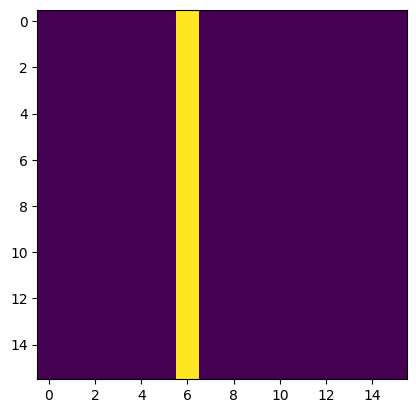

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    plt.imshow(attention, interpolation='nearest')
    plt.show()


In [ ]:
attention

tensor([[4.1652e-05, 1.8743e-08, 4.3531e-15, 1.3554e-17, 2.0464e-16, 1.3552e-08,
         9.9992e-01, 1.8685e-20, 2.9881e-23, 3.2375e-22, 4.0948e-22, 5.8909e-23,
         5.1022e-18, 4.1652e-05, 1.0425e-15, 3.1295e-16],
        [6.9659e-16, 5.0016e-07, 1.9475e-12, 6.0816e-15, 4.3889e-14, 1.0717e-07,
         1.0000e+00, 1.2967e-17, 1.6856e-19, 1.3311e-18, 2.6679e-18, 2.0186e-19,
         6.4972e-16, 6.9659e-16, 3.3120e-14, 1.4395e-14],
        [2.8160e-17, 4.6376e-12, 3.3828e-09, 3.1156e-10, 7.6270e-09, 3.4791e-07,
         1.0000e+00, 1.6709e-13, 7.2155e-15, 7.7347e-15, 2.2479e-14, 1.4072e-14,
         3.9355e-12, 2.8160e-17, 7.8200e-14, 8.5553e-14],
        [8.9966e-22, 3.2495e-17, 1.8656e-13, 6.4120e-14, 1.5420e-11, 2.0936e-09,
         1.0000e+00, 3.8246e-18, 1.3870e-19, 3.8302e-19, 3.0957e-18, 2.5225e-19,
         1.7452e-17, 8.9966e-22, 3.4182e-18, 3.9053e-18],
        [1.0318e-33, 1.2762e-28, 2.2427e-30, 7.8236e-32, 1.9107e-27, 3.6965e-22,
         1.0000e+00, 3.1281e-36, 1.3927